In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as scipy
from scipy.spatial import KDTree
import json
# graph representation
import networkx as nx
# Pulser imports
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice
from pulser.waveforms import InterpolatedWaveform

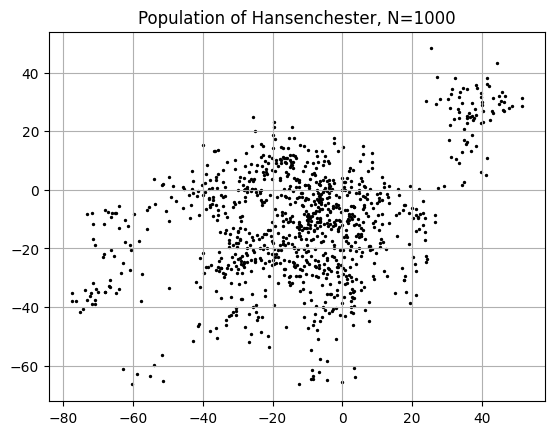

In [8]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[2]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))
plt.grid(True)

In [4]:
def generate_triangular_grid(side_lengths, spacing, offset):
    rows, cols = side_lengths
    points = []
    for row in range(rows):
        for col in range(cols):
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points 

In [17]:
# Problem Parameters
population_x = x # x coordinates of the population
population_y = y # y coordinates of the population
R_antennas = 25  # Operating radius for each antenna
max_antennas = 70  # Maximum number of antennas
minimum_coverage = 0.7 * len(population_x) # Minimum coverage of the population required


In [6]:
def generate_triangular_grid(side_lengths, spacing, offset):
    rows, cols = side_lengths
    points = []
    for row in range(rows):
        for col in range(cols):
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points 

In [12]:
# Parameters in rad/µs and ns
Omega_max = 2.0 * 2 * np.pi
U = Omega_max / 2.0

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000

R_interatomic = AnalogDevice.rydberg_blockade_radius(U)
factor_R_to_Rb = R_antennas/R_interatomic

print('R_interatomic', R_interatomic)
print('factor_R_to_Rb', factor_R_to_Rb)

R_interatomic 7.186760677748386
factor_R_to_Rb 3.478618688027957


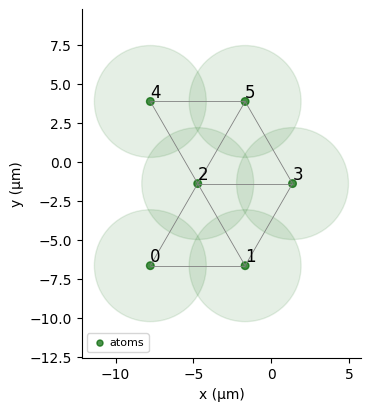

In [25]:
# Grid Parameters
spacing = 0.7*R_antennas*factor_R_to_Rb  # Spacing between antennas
offset = (population_x.min(), population_y.min())  # Offset for the grid
side_lengths = (int(np.ceil((population_x.max() - population_x.min())/spacing)), int(np.ceil((population_y.max() - population_y.min())/spacing)))  # Number of antennas in each direction
grid_points = generate_triangular_grid(side_lengths=side_lengths, spacing=spacing, offset=offset)  # Generate the grid points
qubits = dict(enumerate(np.array(grid_points)/10))
# create a register on NAQC
reg = Register(qubits)
reg.draw(
    blockade_radius=R_interatomic,
    draw_graph=True,
    draw_half_radius=True,
)

In [80]:
# time required to do a pi-pulse
t_pi = np.pi / U
# number of segment for the detuning
segment_number = 5
# number of time intervals for the detuning
time_interval_number = 2*segment_number - 3
# effective depth for the duration of the pulse
depth = 4
sweep_time = depth * t_pi * 1e3 # duration for a pi-pulse in ns
print(f'Sweep Time = {sweep_time} ns for an effective depth of {depth} and a pi-pulse time of {t_pi} ns')

Sweep Time = 2000.0 ns for an effective depth of 4 and a pi-pulse time of 0.5 ns


In [78]:
# parametrized sequence
param_seq = Sequence(reg, AnalogDevice)
param_seq.declare_channel("rydberg_global", "rydberg_global", initial_target=0)
# optimization parameters
amp_vals = param_seq.declare_variable("amp_vals", size=4, dtype=float)
det_vals = param_seq.declare_variable("det_vals", size=segment_number, dtype=float)

ts = np.array([0.1,0.15,0.95,1.0])


amp_wf = InterpolatedWaveform(sweep_time, amp_vals, times=ts)
det_wf = InterpolatedWaveform(
    sweep_time, det_vals, interpolator="interp1d", kind="cubic"
)
pls = Pulse(amp_wf, det_wf, 0)

param_seq.add(pls, "rydberg_global")

In [79]:
seq1 = param_seq.build(amp_vals=[0, 2, 2, 0], det_vals=[0, -5, 5, -5, -2])
seq1.draw()

ValueError: All samples of an amplitude waveform must be greater than or equal to zero.